In [1]:
import pandas as pd
import zipfile
import os
import sys
from datetime import datetime
from datetime import timedelta
import numpy as np
pd.set_option('display.max_columns', 500)

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
# dateparse = lambda x: pd.datetime.strptime(x, '%Y-%m-%d')
vars_serg = ["estadoOrden","Ciudad","Departamento",
             "stado_producto","Marca","Pasillo","Categoria",
             "ProductoEnPromocion","cantidadVendida",
             "TotalPagado","Domicilio","PrecioFinal",
             "FechaCreaciónOrden"]

In [4]:
vars_group_b = ["FechaCreaciónOrden",
                'month_year',
                "Ciudad",
                "Departamento",
                "estadoOrden",
                "stado_producto",
                "Marca",
                "Pasillo",
                "Categoria",
                "ProductoEnPromocion"]

In [5]:
df_p = pd.read_csv("../Data/MERQ_CONS",
                      usecols=vars_serg,
                      encoding='latin1',
                     dtype={'estadoOrden' : str,
                            'TotalPagado' : np.float64,
                            "Domicilio" : str,
                            "FechaCreaciónOrden" : str,
                            "FechaProgramaciónOrden" : str,
                            "FechadeEntregaOrden" : str,
                            "Ciudad" : str,
                            "fechacreacionProducto" : str,
                            "stado_producto" : str,
                            "Marca" : str,
                            "Departamento" : str,
                            "Pasillo" : str,
                            "Categoria" : str,
                            "ProductoEnPromocion" : np.float64,
                            "cantidadVendida" : np.float64,
                            "PrecioFinal": np.float64})

In [6]:
df_p = df_p.dropna()
df_p = df_p[(df_p.cantidadVendida>0) & 
            (df_p.TotalPagado>0)]
df_p["cuenta_gr"] = [1]*df_p.shape[0]
df_p['FechaCreaciónOrden'] = pd.to_datetime(df_p.FechaCreaciónOrden)
df_p['month_year'] = df_p.FechaCreaciónOrden.apply(lambda x: "%d-%d" % (x.year,x.month))
df_p.set_index("FechaCreaciónOrden",inplace=True,drop=False)

In [7]:
df_p.sort_values("FechaCreaciónOrden",inplace=True)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: 'FechaCreaciónOrden' is both an index level and a column label.
Defaulting to column, but this will raise an ambiguity error in a future version
  """Entry point for launching an IPython kernel.


In [8]:
df_p.columns

Index(['estadoOrden', 'TotalPagado', 'Domicilio', 'FechaCreaciónOrden',
       'Ciudad', 'stado_producto', 'Marca', 'Departamento', 'Pasillo',
       'Categoria', 'cantidadVendida', 'ProductoEnPromocion', 'PrecioFinal',
       'cuenta_gr', 'month_year'],
      dtype='object')

In [9]:
from math import ceil

def week_of_month(dt):
    """ Returns the week of the month for the specified date.
    """

    first_day = dt.replace(day=1)

    dom = dt.day
    adjusted_dom = dom + first_day.weekday()

    return str(int(ceil(adjusted_dom/7.0)))

In [10]:
serie = df_p[["FechaCreaciónOrden","Pasillo","Ciudad","TotalPagado","cuenta_gr","cantidadVendida"]].groupby(["FechaCreaciónOrden","Pasillo","Ciudad"],
                                                                                  as_index=False).sum()

serie.set_index("FechaCreaciónOrden",inplace=True,drop=False)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: 'FechaCreaciónOrden' is both an index level and a column label.
Defaulting to column, but this will raise an ambiguity error in a future version
  


In [11]:
serie["Month"] = serie.FechaCreaciónOrden.apply(lambda x: "%d" % x.month)
serie["year"] = serie.FechaCreaciónOrden.apply(lambda x: "%d" % x.year)
serie["week"] = serie.FechaCreaciónOrden.apply(week_of_month)


In [12]:
caegorias_selected = serie.groupby("Pasillo").sum().sort_values("cantidadVendida",ascending=False)

In [13]:
caegorias_selected = caegorias_selected[caegorias_selected.cantidadVendida>60000]
caegorias_selected = caegorias_selected.index.tolist()

In [14]:
serie[serie.Pasillo.isin(caegorias_selected)].cuenta_gr.sum()/serie.cuenta_gr.sum()

0.82928403463230993

In [15]:
serie = serie[serie.Pasillo.isin(caegorias_selected)]

In [16]:
serie["split_index"] = np.arange(0,len(serie))

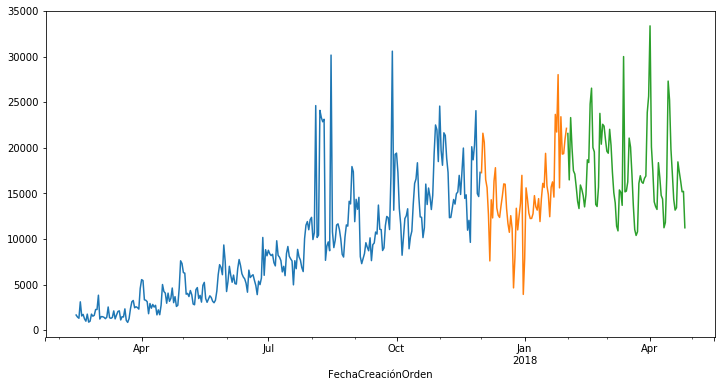

In [17]:
a = serie[(serie.Pasillo.isin(caegorias_selected))].cantidadVendida.resample("D").sum()
plt.figure(figsize=(12,6))
a[:'2017-11'].plot()
a['2017-12':'2018-01'].plot()
a['2018-02':].plot()

In [18]:
y1 = a[:'2017-11'].values
y2 = a['2017-12':'2018-01'].values
y3 = a['2018-02':].values

In [19]:
n_bins=np.linspace(0, max(max(y1),max(y2),max(y3)), 25)

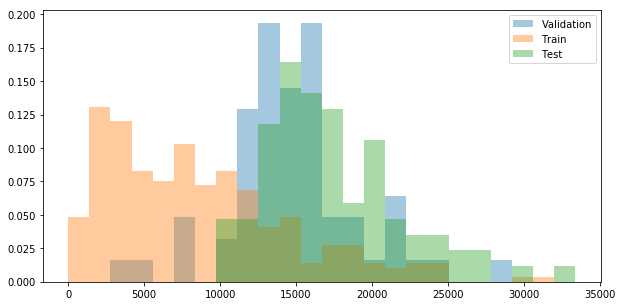

In [20]:
## gCompare
plt.figure(figsize=(10,5))
sns.distplot(y2, kde=False,bins=n_bins,
             hist_kws={'weights': np.full(len(y2), 1/len(y2)),
                       'label':"Validation"})
sns.distplot(y1, kde=False,bins=n_bins,
             hist_kws={'weights': np.full(len(y1), 1/len(y1)),
                       'label':"Train"})
sns.distplot(y3, kde=False,bins=n_bins,
             hist_kws={'weights': np.full(len(y3), 1/len(y3)),
                       'label':"Test"})
plt.legend()
plt.show()

In [21]:
y1.shape,y2.shape

((291,), (62,))

In [22]:
from statsmodels.tsa.stattools import acf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import pacf
from statsmodels.graphics.tsaplots import plot_pacf

In [23]:
# acf_y1, ci, Q, pvalue = acf(y1, nlags=4,qstat=True,alpha=.05,unbiased=True)

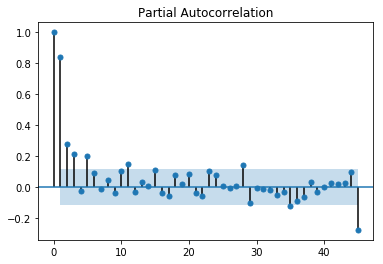

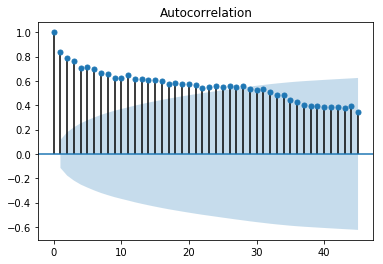

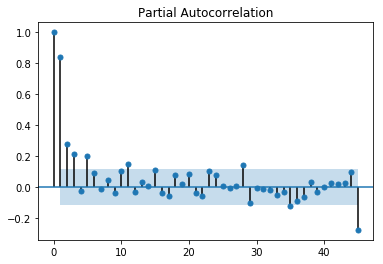

In [24]:
plot_acf(y1,alpha=0.05,lags=45)
plot_pacf(y1,alpha=0.05,lags=45)

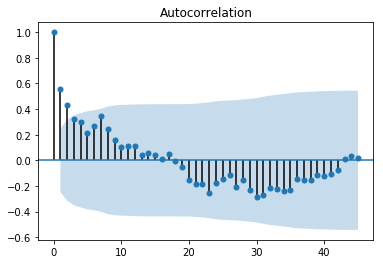

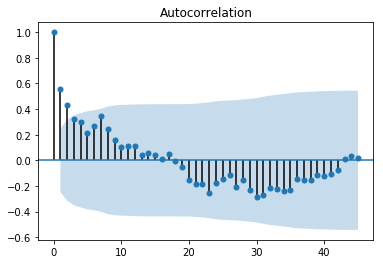

In [25]:
plot_acf(y2,alpha=0.05,lags=45)

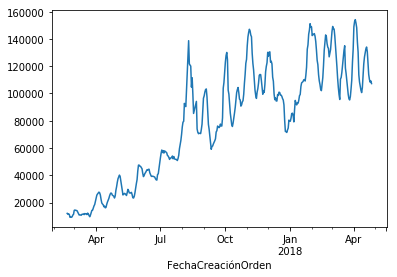

In [26]:
# a.plot()
a.rolling(window=7).sum().plot()

In [27]:
serie.cuenta_gr.sum()

3808370

In [28]:
serie.head()

,FechaCreaciónOrden,Pasillo,Ciudad,TotalPagado,cuenta_gr,cantidadVendida,Month,year,week,split_index
FechaCreaciónOrden,,,,,,,,,,
2017-02-13,2017-02-13,Aceites y aderezos,Bogotá,2052996.0,19,20.0,2,2017,3,0
2017-02-13,2017-02-13,Aguas,Bogotá,227546.0,5,8.0,2,2017,3,1
2017-02-13,2017-02-13,Arepas,Bogotá,589900.0,9,9.0,2,2017,3,2
2017-02-13,2017-02-13,Aseo general,Bogotá,2605300.0,24,28.0,2,2017,3,3
2017-02-13,2017-02-13,Azúcar y endulzantes,Bogotá,2249050.0,34,46.0,2,2017,3,4


In [29]:
serie.dtypes

FechaCreaciónOrden    datetime64[ns]
Pasillo                       object
Ciudad                        object
TotalPagado                  float64
cuenta_gr                      int64
cantidadVendida              float64
Month                         object
year                          object
week                          object
split_index                    int64
dtype: object

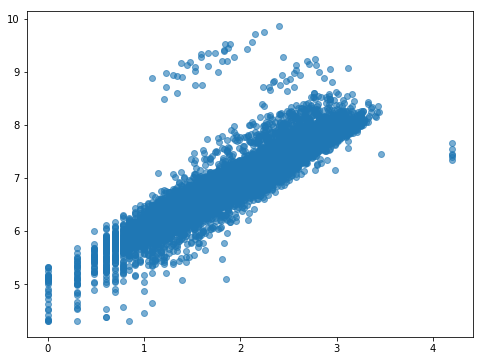

In [30]:
plt.figure(figsize=(8,6))
plt.scatter(np.log10(serie.cantidadVendida),
        np.log10(serie.TotalPagado),
            alpha = 0.6)

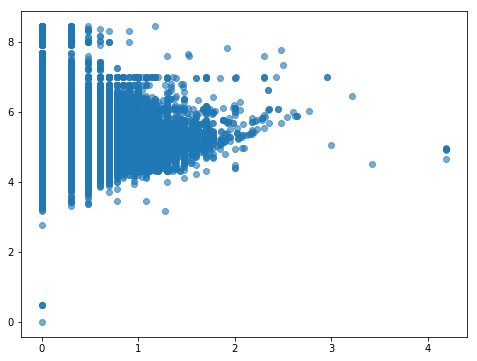

In [31]:
plt.figure(figsize=(8,6))
plt.scatter(np.log10(df_p.cantidadVendida),
        np.log10(df_p.TotalPagado),
            alpha = 0.6)

In [32]:
serie.dtypes

FechaCreaciónOrden    datetime64[ns]
Pasillo                       object
Ciudad                        object
TotalPagado                  float64
cuenta_gr                      int64
cantidadVendida              float64
Month                         object
year                          object
week                          object
split_index                    int64
dtype: object

In [33]:
serie.head()

,FechaCreaciónOrden,Pasillo,Ciudad,TotalPagado,cuenta_gr,cantidadVendida,Month,year,week,split_index
FechaCreaciónOrden,,,,,,,,,,
2017-02-13,2017-02-13,Aceites y aderezos,Bogotá,2052996.0,19,20.0,2,2017,3,0
2017-02-13,2017-02-13,Aguas,Bogotá,227546.0,5,8.0,2,2017,3,1
2017-02-13,2017-02-13,Arepas,Bogotá,589900.0,9,9.0,2,2017,3,2
2017-02-13,2017-02-13,Aseo general,Bogotá,2605300.0,24,28.0,2,2017,3,3
2017-02-13,2017-02-13,Azúcar y endulzantes,Bogotá,2249050.0,34,46.0,2,2017,3,4


In [34]:
def get_feat_y(df):
    dum = pd.get_dummies(df[["Pasillo","Ciudad","Month","week"]],drop_first=True)
    print(dum.shape)
    X = pd.concat([df[["TotalPagado","cuenta_gr"]],dum],axis=1)
    mat_corr = X.corr()
    x_scl = scaler.fit_transform(X)
    Y = df.cantidadVendida.values
    val_names = X.columns.tolist()
    return {'X':x_scl,'Y':Y,
            'colnames':val_names,
            'mat_corr':mat_corr}

In [37]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler(with_mean=False)
train_index = serie[:'2017-11']["split_index"].values
val_index = serie['2017-12':'2018-01']["split_index"].values
test_index = serie['2018-02':]["split_index"].values
df_mod = get_feat_y(serie)

(24303, 50)


In [38]:
X_train = df_mod["X"][train_index]
Y_train = df_mod["Y"][train_index]

X_val = df_mod["X"][val_index]
Y_val = df_mod["Y"][val_index]

X_test = df_mod["X"][test_index]
Y_test = df_mod["Y"][test_index]

In [39]:
X_train.shape,X_val.shape,X_test.shape

((14310, 52), (4213, 52), (5780, 52))

In [66]:
df_mod.keys()

dict_keys(['X', 'Y', 'colnames', 'mat_corr'])

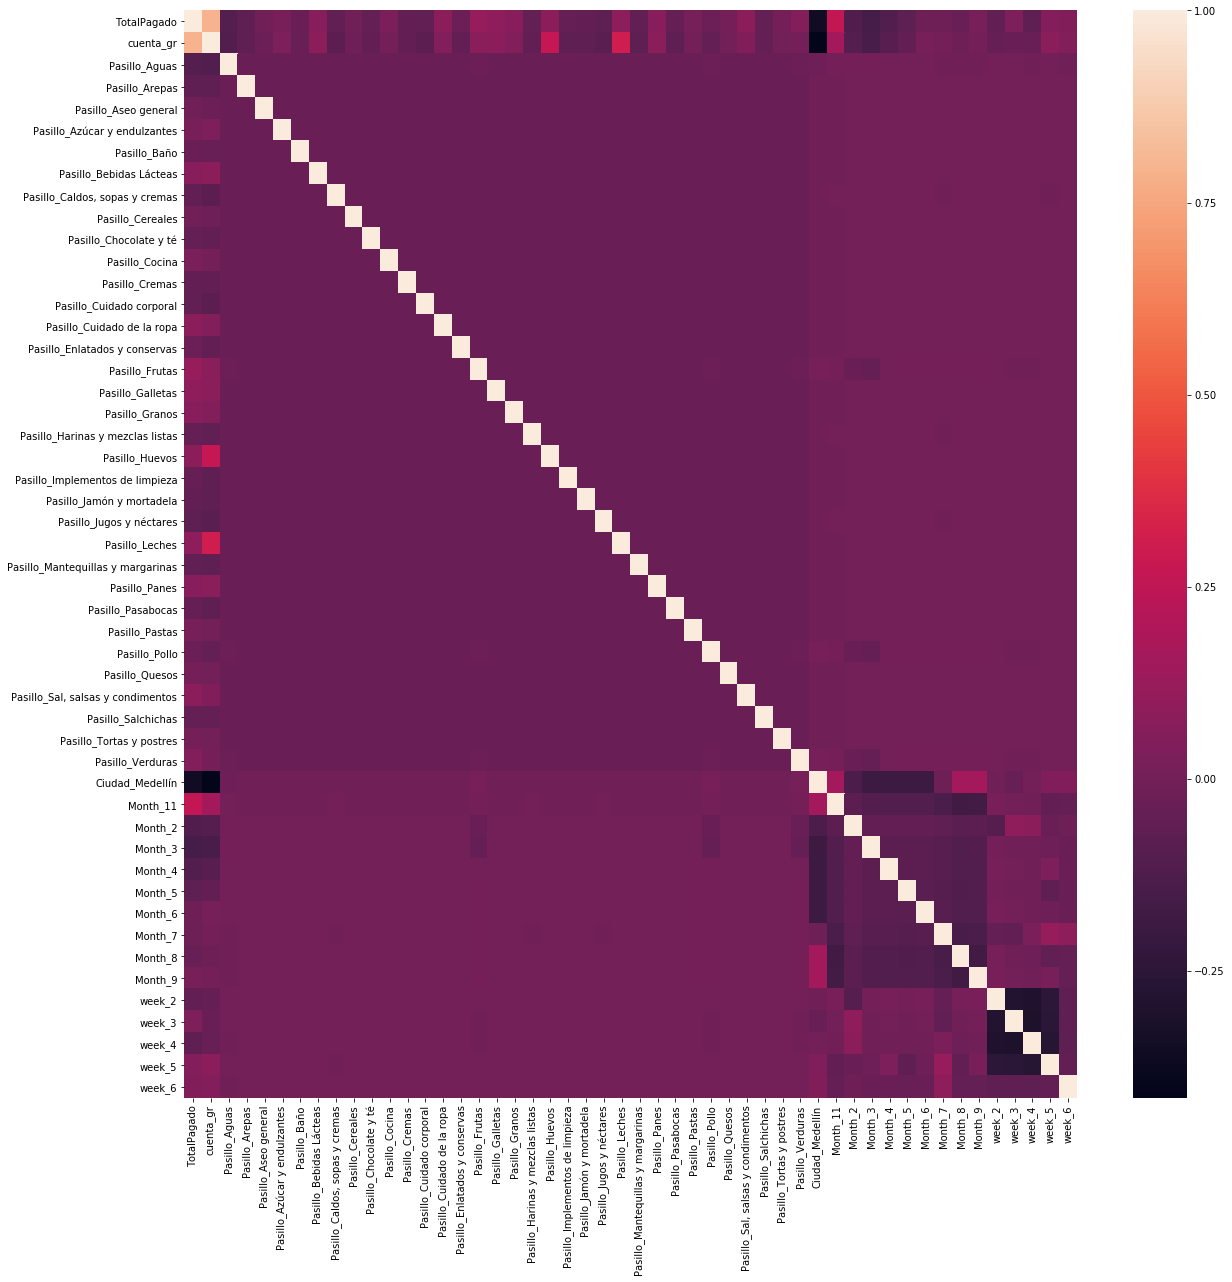

In [47]:
plt.figure(figsize=(20,20))
sns.heatmap(X_train["mat_corr"])
plt.show()

In [48]:
serie.head()

,FechaCreaciónOrden,Pasillo,Ciudad,TotalPagado,cuenta_gr,cantidadVendida,Month,year,week
FechaCreaciónOrden,,,,,,,,,
2017-02-13,2017-02-13,Aceites y aderezos,Bogotá,2052996.0,19,20.0,2,2017,3
2017-02-13,2017-02-13,Aguas,Bogotá,227546.0,5,8.0,2,2017,3
2017-02-13,2017-02-13,Arepas,Bogotá,589900.0,9,9.0,2,2017,3
2017-02-13,2017-02-13,Aseo general,Bogotá,2605300.0,24,28.0,2,2017,3
2017-02-13,2017-02-13,Azúcar y endulzantes,Bogotá,2249050.0,34,46.0,2,2017,3


In [40]:
from sklearn import tree
from sklearn.model_selection import cross_val_score
from sklearn import metrics
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import GridSearchCV

In [41]:
sc_tree = tree.DecisionTreeRegressor(criterion="mae",random_state=29)

In [59]:
param_search = {'max_depth' : [2,3]}

In [60]:
my_cv = TimeSeriesSplit(n_splits=10).split(X_train,Y_train)
gsearch = GridSearchCV(estimator=sc_tree, cv=my_cv,
                       param_grid=param_search,
                       n_jobs=6,
                       verbose=1)

In [61]:
gsearch.fit(X_train,Y_train)

Fitting 10 folds for each of 2 candidates, totalling 20 fits


[Parallel(n_jobs=6)]: Done   9 out of  20 | elapsed:    4.7s remaining:    5.8s
[Parallel(n_jobs=6)]: Done  20 out of  20 | elapsed:   37.2s finished


GridSearchCV(cv=<generator object TimeSeriesSplit.split at 0x7f8593fce678>,
       error_score='raise',
       estimator=DecisionTreeRegressor(criterion='mae', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=29, splitter='best'),
       fit_params=None, iid=True, n_jobs=6,
       param_grid={'max_depth': [2, 3]}, pre_dispatch='2*n_jobs',
       refit=True, return_train_score='warn', scoring=None, verbose=1)

In [45]:
gsearch.best_estimator_

DecisionTreeRegressor(criterion='mae', max_depth=5, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=29, splitter='best')

In [46]:
metrics.mean_absolute_error(gsearch.best_estimator_.predict(X_val),
                            Y_val)

26.097911227154047

In [47]:
metrics.mean_absolute_error(gsearch.best_estimator_.predict(X_test),
                            Y_test)

33.848529411764709

In [48]:
clf =  tree.DecisionTreeRegressor(criterion='mae',max_depth=5)
clf.fit(X_train,Y_train)

DecisionTreeRegressor(criterion='mae', max_depth=5, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best')

In [63]:
from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus
dot_data = StringIO()
export_graphviz(clf, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
graph.write_pdf("tree.pdf")

InvocationException: GraphViz's executables not found

In [67]:

with open("fruit_classifier.txt", "w") as f:
    f = export_graphviz(gsearch.best_estimator_,out_file=f,feature_names=df_mod["colnames"])


In [49]:
! sudo apt-get install graphviz

[sudo] password for jovyan: 


In [54]:
! pip install graphviz


You are using pip version 9.0.3, however version 18.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
